In [1]:
from typing import *
from pathlib import Path
import itertools
import pandas as pd
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy.stats
from statsmodels.stats.multitest import fdrcorrection
import mdsine2 as md2
from mdsine2.names import STRNAMES
from tqdm.notebook import tqdm


from analysis.feasy import *

# Make font editable in AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

[DEBUG] Using default logger (stdout, stderr).


## Merged Fixed Cluster: replicate the outcome in Figure 6

In [2]:
data_dir = Path('./datasets/gibson/output/mdsine2/inference')

def modules_from_cocluster(M) -> Iterator[np.ndarray]:
    indices = set(range(M.shape[-1]))
    while len(indices) > 0:
        v = next(iter(indices))
        module = np.where(M[v])[0]
        for w in module:
            indices.remove(w)
        yield module
        
def extract_interactions(mcmc: md2.BaseMCMC) -> np.ndarray:
    interactions = mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk(section='posterior')
    interactions[np.isnan(interactions)] = 0

    self_interactions = mcmc.graph[STRNAMES.SELF_INTERACTION_VALUE].get_trace_from_disk(section='posterior')
    self_interactions = -np.absolute(self_interactions)

    for i in range(self_interactions.shape[1]):
        interactions[:, i, i] = self_interactions[:, i]
    return interactions

def extract_module_interaction(mcmc: md2.BaseMCMC) -> Iterator[np.ndarray]:
    interactions = extract_interactions(mcmc)
    cocluster = mcmc.graph[STRNAMES.CLUSTERING_OBJ].coclusters.get_trace_from_disk(section='posterior')

    n_samples = interactions.shape[0]

    for i in range(n_samples):
        modules = list(modules_from_cocluster(cocluster[i]))
        module_reps = [next(iter(module)) for module in modules]
        module_interactions = interactions[i][np.ix_(module_reps, module_reps)]
        for j in range(module_interactions.shape[0]):
            module_interactions[j, j] = 0.
        yield module_interactions
        
def module_interactions_all(mcmc_paths: Path) -> Iterator[np.ndarray]:
    """
    Extract the interaction matrices from the MCMC pickle path.
    """
    for mcmc_path in mcmc_paths:
        mcmc = md2.BaseMCMC.load(str(mcmc_path))
        yield from extract_module_interaction(mcmc)

def count_cycles(A: np.ndarray, cycle_sgn: str):
    matrices = [
        A > 0 if sgn == "+" 
        else A < 0 if sgn == "-"
        else None
        for sgn in cycle_sgn
    ]

    prod = matrices[0].astype(int)
    for m in matrices[1:]:
        prod = prod @ m

    return np.diag(prod).sum()

def count_edges(A: np.ndarray, sgn: str):
    matrices = (
        A > 0 if sgn == "+" 
        else A < 0 if sgn == "-"
        else A == 0 if sgn == "0"
        else None
    )

    return np.sum(matrices)

# count how many times the interactions turn on vs. turn off, compared to prior pseduocounts
def interaction_bayes_factors(interactions: np.ndarray, prior_a: float, prior_b: float) -> np.ndarray:
    trace = ~np.isnan(interactions)
    cnts_1 = np.sum(trace, axis=0)
    cnts_0 = np.sum(1-trace, axis=0)

    return (cnts_1 * prior_b) / (cnts_0 * prior_a)

class MdsineOutput(object):
    def __init__(self, pkl_path):
        self.mcmc = md2.BaseMCMC.load(pkl_path)
        self.taxa = self.mcmc.graph.data.taxa
        self.name_to_taxa = {otu.name: otu for otu in self.taxa}

        self.interactions = None
        self.clustering = None

        self.clusters_by_idx = {
            (c_idx): [self.get_taxa(oidx) for oidx in cluster.members]
            for c_idx, cluster in enumerate(self.get_clustering())
        }

    @property
    def num_samples(self) -> int:
        return self.mcmc.n_samples

    def get_cluster_df(self):
        return pd.DataFrame([
            {
                "id": cluster.id,
                "idx": c_idx+1,
                "otus": ",".join([self.get_taxa(otu_idx).name for otu_idx in cluster.members]),
                "size": len(cluster)
            }
            for c_idx, cluster in enumerate(self.clustering)
        ])

    def get_interactions(self):
        if self.interactions is None:
            self.interactions = self.mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk(section='posterior')
        return self.interactions

    def extract_entire_interactions(self):
        if self.interactions is None:
            self.interactions = self.mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk(section='posterior')
        
        entire_interactions = self.interactions.copy()

        intra_interactions = self.mcmc.graph[STRNAMES.SELF_INTERACTION_VALUE].get_trace_from_disk(section='posterior')
        intra_interactions = -np.absolute(intra_interactions)

        for i in range(intra_interactions.shape[1]):
            entire_interactions[:, i, i] = intra_interactions[:, i]

        return entire_interactions


    def get_taxa(self, idx):
        return self.taxa.index[idx]

    def get_taxa_by_name(self, name: str):
        return self.name_to_taxa[name]

    def get_taxa_str(self, idx):
        tax = self.taxa.index[idx].taxonomy
        family = tax["family"]
        genus = tax["genus"]
        species = tax["species"]

        if genus == "NA":
            return "{}**".format(family)
        elif species == "NA":
            return "{}, {}*".format(family, genus)
        else:
            return "{}, {} {}".format(family, genus, species)

    def get_taxa_str_long(self, idx):
        return "{}\n[{}]".format(self.get_taxa(idx).name, self.get_taxa_str(idx))

    def get_clustering(self):
        if self.clustering is None:
            self.clustering = self.mcmc.graph[STRNAMES.CLUSTERING_OBJ]
            for cidx, cluster in enumerate(self.clustering):
                cluster.idx = cidx
        return self.clustering

    def get_clustered_interactions(self):

        clusters = self.get_clustering()
        otu_interactions = self.get_interactions()
        cluster_interactions = np.zeros(
            shape=(
                otu_interactions.shape[0],
                len(clusters),
                len(clusters)
            ),
            dtype=float
        )
        cluster_reps = [
            next(iter(cluster.members)) for cluster in clusters
        ]
        for i in range(cluster_interactions.shape[0]):
            cluster_interactions[i] = otu_interactions[i][np.ix_(cluster_reps, cluster_reps)]
        return cluster_interactions
    
n_modules = len(set(np.load(data_dir / 'merged_studies' / 'agglomeration.npy')))
a = 0.5; b = n_modules * (n_modules - 1) # prior of indicators
md_fixed_module = MdsineOutput(data_dir / 'merged_studies_fixed_cluster' / 'mcmc.pkl')

In [45]:
# Visualization

def visualize_bf_log10(bf: np.ndarray):
    vis_bf = np.log10(bf)
    vis_bf[np.isinf(vis_bf)] = np.nan

    cmap = plt.cm.viridis
    cmap.set_bad(color='white')

    plt.figure(figsize=(3, 2.25), dpi=150)
    im = plt.imshow(vis_bf, cmap=cmap, interpolation='nearest', aspect='auto')
    cbar = plt.colorbar(im)

    plt.title('log10(BF)')
    plt.show()

def visualize_signs_under_bf(signs: np.ndarray, bf: Optional[np.ndarray] = None, threshold: Optional[float] = None):
    if bf is not None and threshold is not None:
        signs[bf < threshold] = 0
    
    cmap = ListedColormap(['red', 'white', 'blue'])
    plt.figure(figsize=(3, 2.25), dpi=150)
    im = plt.imshow(signs, cmap=cmap, interpolation='nearest', aspect='auto')
    cbar = plt.colorbar(im, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(['-', '0', '+'])

    if threshold is not None:
        plt.title(f'mod-mod inte signs (BF > {threshold})')
    else:
        plt.title('mod-mod inte signs')
    plt.show()

def visualize_signs_margin(margins: np.ndarray, ax:Optional[plt.Axes]=None):
    cmap = sb.color_palette("coolwarm", as_cmap=True)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_coolwarm", 
        [(0.0, "blue"), (0.5, "white"), (1.0, "red")]
    )
    plt.figure(figsize=(3, 2.25), dpi=150)
    sb.heatmap(margins,
        cmap=cmap,
        square=True,
        xticklabels=False, 
        yticklabels=False, 
        cbar=True,
        ax=ax
    )
    plt.show()


# visualize a snapshot of the sampling
def visualize_interaction(A):
    
    cmap = sb.color_palette("coolwarm", as_cmap=True)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_coolwarm", 
        [(0.0, "blue"), (0.5, "white"), (1.0, "red")]
    )
    plt.figure(figsize=(3, 2.25), dpi=150)
    sb.heatmap(A,
        cmap=cmap,
        norm=mcolors.SymLogNorm(linthresh=1e-9, vmin=-1e-8, vmax=1e-8, base=10),
        mask=np.isnan(A),
        square=True,
        xticklabels=False, 
        yticklabels=False, 
        cbar=True,
    )
    plt.show()

Follow Figure6, we can replicate the snapshots of signs filtered at different BF levels

In [4]:
intes0 = md_fixed_module.get_clustered_interactions()

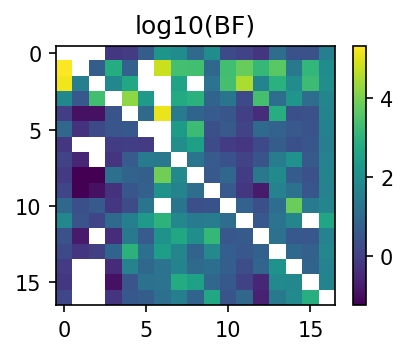

In [5]:
# A fancy way to express the distribution of on/off
bf0 = interaction_bayes_factors(intes0, a, b) # accessing consistency of on/off interactions
visualize_bf_log10(bf0)

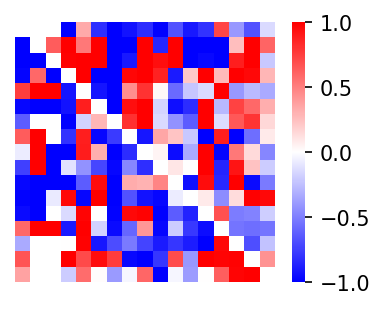

In [ ]:
# the specific way to render sign structures as in Figure 6 of the paper
signs0 = np.sign(np.sum(intes0 > 0, axis=0) - np.sum(intes0 < 0, axis=0))
margins0 = (np.sum(intes0 > 0, axis=0) - np.sum(intes0 < 0, axis=0))/(np.sum(intes0 > 0, axis=0) + np.sum(intes0 < 0, axis=0))

# visualize_signs_under_bf(signs0, bf0, 3.1623)
visualize_signs_margin(margins0)


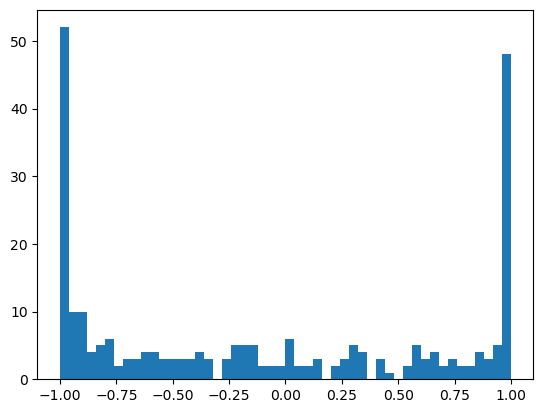

In [69]:
plt.hist(margins0.flatten(), bins = 50)
plt.show()

Note that self-interaction terms are not included yet, but can be recovered in the origianl species-species interaction inference

In [7]:
# fixed-module inference of species-species interactions; with self-interactions; nan for indicator turned off
intes = md_fixed_module.extract_entire_interactions()

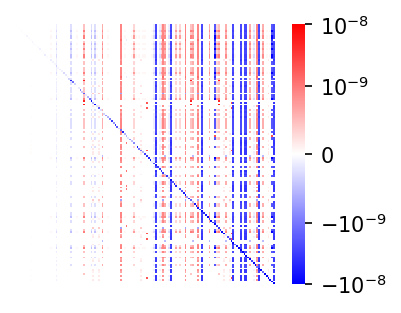

In [8]:
# snapshot of the moduled interaction at time 10k, clearly see modular interaction enforced
visualize_interaction(intes[5000,])

## Merged fixed cluster: Feasibility of sub-networks
Focus on a representative samll taxon pool, let's try to compute the distribution of feasibility for that.

We will sample the modular interaction network, where the dimensionality is reduced and nonnegative interaction is more common

In [56]:
# Sample intes with cluster reps. Self-interaction will be dependent on the reps we choose
clusters = md_fixed_module.get_clustering()
cluster_reps = [
    next(iter(cluster.members)) for cluster in clusters
]
cluster_reps

[129, 3, 0, 128, 68, 96, 132, 139, 99, 91, 64, 41, 8, 117, 60, 37, 135]

In [58]:
rows = cols = np.array([129, 3, 0, 128]) # generates a feasibility distribution of 1e-5 to 1e-6

intes = md_fixed_module.extract_entire_interactions()
subintes = intes[:, np.ix_(rows, cols)[0], np.ix_(rows, cols)[1]]
subintes[np.isnan(subintes)] = 0
np.sum(subintes!=0, axis=0)

array([[10000,     0,     0,    12],
       [ 9975, 10000,    89,  5459],
       [ 9965,   623, 10000,  1088],
       [ 1089,    63,  8042, 10000]])

In [59]:
# generate the trace of feasibility in real mcmc outcome (base)
feas = []
for i in range(subintes.shape[0]):
    feas.append(feasibility_community(1e10*subintes[i]))

In [60]:
feas_array = np.array(feas)
feas_filtered = feas_array[feas_array >= 0.001]

In [61]:
# generate the trace of feasibility from Gaussian random ensemble (random)
n_diag = subintes.shape[1]
n_offdiag = n_diag * (n_diag - 1)

conne = (np.mean([np.sum(inte!=0) for inte in subintes]) - n_diag)/n_offdiag
mean = np.mean(subintes[:, ~np.eye(n_diag, dtype=bool)])
std = np.std(subintes[:, ~np.eye(n_diag, dtype=bool)])
print(conne, mean, std) 

0.303375 -2.3432389317904095e-11 6.367609538071167e-11


In [62]:
feas_rand = []
for i in range(subintes.shape[0]):
    rand_inte = sample_inte_norm(n_diag, conne, mean, std)
    feas_rand.append(feasibility_community(1e10*rand_inte))

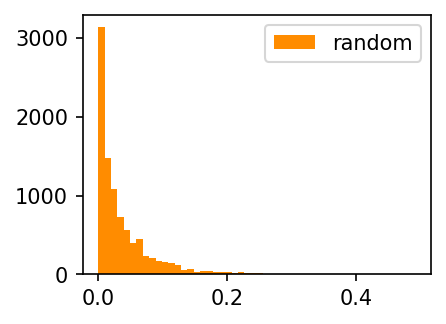

In [70]:
# plot histogram of feas_trace against randomized feas_trace_rand, blue and darkorange
plt.figure(figsize=(3, 2.25), dpi=150)
plt.hist(feas_rand, bins=50, color='darkorange', alpha=1, label='random')
# plt.hist(feas, bins=100, color='blue', alpha=0.65, label='base')

plt.legend()
plt.show()

Potential advantage of no-one-network 1: measurement on a single point likely conclude only self-loop interactions. But in the probable case of off-diagonal interaction links, there hides important information of feasible interaction networks.

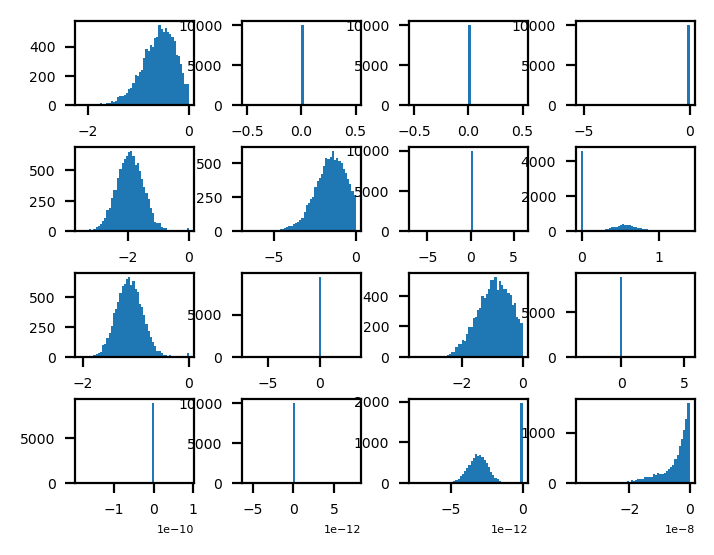

In [18]:
# Plot the histogram of edges
fig, axes = plt.subplots(n_diag, n_diag, figsize=(4, 3), dpi=200)

for i in range(n_diag):
    for j in range(n_diag):
        ax = axes[i, j]
        ax.hist(subintes[:, i, j], bins=50)
        # ax.set_xlabel(f'a_{{{i+1},{j+1}}}', fontsize=5)
        ax.tick_params(axis='both', which='major', labelsize=5)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))
        ax.xaxis.get_offset_text().set_fontsize(4)

# Adjust spacing
plt.subplots_adjust(wspace=0.4, hspace=0.5)  # Smaller horizontal and vertical spacing
plt.show()

## No module inference outcome

In [9]:
data_dir = Path('./datasets/gibson/output/mdsine2/inference')
seed_paths = [data_dir / f"healthy-seed{seed}-nomodule" / "mcmc.pkl"
              for seed in [1203]]

nm1203 = MdsineOutput(data_dir / "healthy-seed1203-nomodule" / 'mcmc.pkl')

In [10]:
intes = nm1203.extract_entire_interactions()

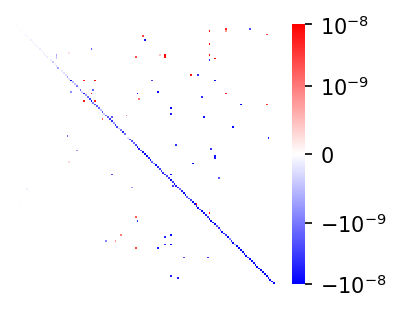

In [13]:
A = intes[4500,]
visualize_interaction(A)

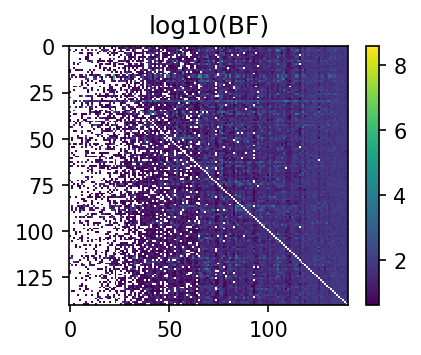

In [12]:
bf = interaction_bayes_factors(intes, 0.5, 141*140)
visualize_bf_log10(bf)

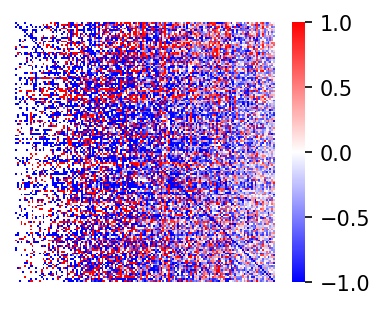

In [48]:
signs = np.sign(np.sum(intes > 0, axis=0) - np.sum(intes < 0, axis=0))
margins = (np.sum(intes > 0, axis=0) - np.sum(intes < 0, axis=0))/(np.sum(intes > 0, axis=0) + np.sum(intes < 0, axis=0))

visualize_signs_margin(margins)

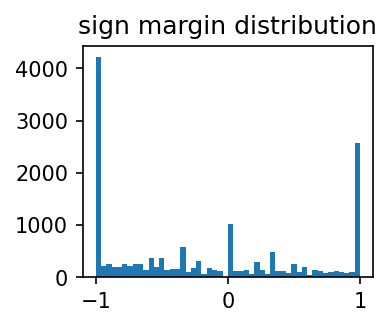

In [55]:
# flattern signs as 1d array and plot histogram
plt.figure(figsize=(2.5, 2), dpi=150)
plt.hist(margins.flatten(), bins=50)
plt.title('sign margin distribution')
plt.show()

In [ ]:
signs_counts = signs.flatten()
cases = np.array((signs_counts > 0.95) | (signs_counts < -0.95) | (np.abs(signs_counts) < 0.05))
np.sum(cases)
np.sum(~cases)

np.int64(11960)

In [105]:
edges = bf > 1000
filt_edges = np.zeros(signs.shape, dtype=int)
filt_edges[edges] = signs[edges]
count_cycles(filt_edges, "-0-0")

np.int64(120768)

In [ ]:
np.argsort(np.sum(np.abs(vis_sgn), axis=1))

array([ 12,  20,  23,  28,  29,  22,  39,  59,  48,  54,  58,  57,  42,
        38,  34, 107,  98, 100,  85,  86,  95,  92,  94,  84,  80,  78,
        77,  79,  71,  70,  67,  64, 116, 123, 127, 103, 108, 109, 110,
       111, 113, 118, 112, 122, 131, 130, 129, 128, 138, 140, 134, 133,
        52,  53,  51,   0,  15,  61,  55,  45,  69,  76,  88,   5,  99,
       120, 106,   7, 136, 137, 132, 135,  11,  14,  25, 124,   9,   4,
       101,  24,  91,  73,  49, 139,   1, 105,  90,  83,  32,   6,  60,
        21,  40,  46,  62,  65, 104, 102,  47,  72, 114, 125,  31, 126,
        74,  81,  68, 117,  13,  27,  18,  44,  66,  56,  96,  10,   3,
        97,  82, 119, 121,  93,  26,  43,  33,  50,  35,   2,  19,  87,
        75,  89,  41,  37,  36,  63, 115,   8,  16,  17,  30])

In [34]:
rows = np.array([8,16,17,30])
cols = np.array([8,16,17,30])
subintes = intes[:, np.ix_(rows, cols)[0], np.ix_(rows, cols)[1]]

Threshold = 3.1622776601683795, # 2-cycles = 19881
Threshold = 10, # 2-cycles = 19881
Threshold = 100, # 2-cycles = 19881


Text(0, 0.5, 'Bayes Factor')

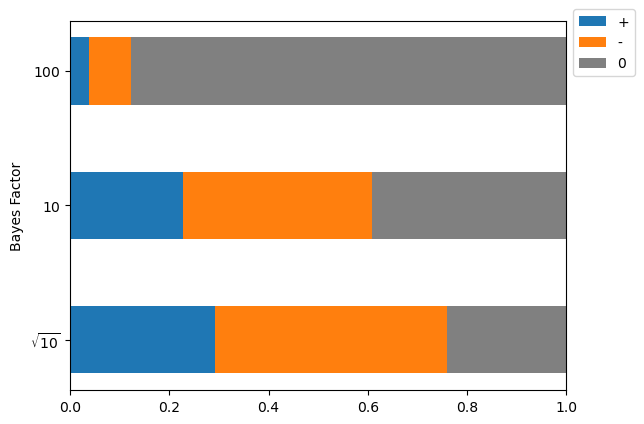

In [129]:
threshold = 1000

signs = np.sign(np.sum(intes > 0, axis=0) - np.sum(intes < 0, axis=0))
edges = bf > threshold
filt_edges = np.zeros(signs.shape, dtype=int)
filt_edges[edges] = signs[edges]


thresholds = [np.sqrt(10), 10, 100]
labels = [
    # r'$1$',
    r'$\sqrt{10}$',
    r'$10$',
    r'$100$'
]

sign_groups = ["+", "-", "0"]
sign_order = [s[0] for s in sign_groups]
sign_colors = {
    '+': 'tab:blue',
    '-': 'tab:orange',
    '0': 'grey',
}

true_counts = np.zeros((len(thresholds), len(sign_groups)), dtype=int)
_locs = {s: i for i, s in enumerate(sign_order)}
for thres_idx, t in enumerate(thresholds):
    edges = bf > t
    filt_edges = np.zeros(signs.shape, dtype=int)
    filt_edges[edges] = signs[edges]
    
    true_counts[thres_idx, _locs['+']] = count_edges(filt_edges, '+')
    true_counts[thres_idx, _locs['-']] = count_edges(filt_edges, '-')
    true_counts[thres_idx, _locs['0']] = count_edges(filt_edges, '0')

true_freqs = true_counts / true_counts.sum(axis=1, keepdims=True)

for t_idx, t in enumerate(thresholds):
    print("Threshold = {}, # 2-cycles = {}".format(t, true_counts[t_idx, :].sum()))

fig, ax = plt.subplots()
offset = np.zeros(len(thresholds))

for sgn_idx, sgns in enumerate(sign_groups):
    h = true_freqs[:, sgn_idx]
    c = sign_colors[sgns[0]]
    ax.barh(labels, h, left=offset, color=c, height=0.5, label='/'.join(sgns[0]))
    offset = offset + h
    
lgd = ax.legend(bbox_to_anchor=(1.0, 1.05), loc='upper left')
ax.set_xlim([0, 1])

ax.set_ylabel('Bayes Factor')